In [70]:
# SETUP

from ml_helpers import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from cv_helpers_copy import load_image, visualize_single_channel, rgb2hsl, visualize_rgb, hsl2rgb

In [81]:
# LOAD IMAGES

images_all, labels_all = load_dataset()

Reading dataset/dataset.yaml... done!
Loading images.................... done!
Loaded 6888 images in 41.27050304412842 seconds!


In [82]:
# PADS IMAGE 

def pad_image(grayscale_image, window_size):
    """Pad the borders of an image with zeros.
    
    Args:
        grayscale_image (np.ndarray): Input image.
        window_size (int): Size of the window we are blurring or convolving over.
            Must be odd.
    
    Returns:
        np.ndarray: Zero-padded image.
    """
    #assert len(grayscale_image.shape) == 2, "Image shape must be (rows, cols)"
    assert window_size % 2 == 1, "Window size must be odd!"
    pad_amount = window_size // 2

    # Note: we've explicitly written out the pad operation here to be explicit,
    # but we could also use the built-in `np.pad()` function
    padded_image = np.zeros(
        shape=(
            grayscale_image.shape[0] + pad_amount * 2,
            grayscale_image.shape[1] + pad_amount * 2,
        )
    )
    padded_image[
        pad_amount:-pad_amount, pad_amount:-pad_amount
    ] = grayscale_image

    return padded_image


In [146]:
# CONVOLVES WITH INPUT KERNEL
# LATER USED STANDARDISED CONVOLVE FUNCTION TO SPEED THINGS UP

"""
def convolve2d(grayscale_image, kernel):
    Applies the convolution operation to an input image.
    
    Args:
        grayscale_image (np.ndarray): Input image.
        kernel (np.ndarray): Square kernel to convolve with.
    
    Returns:
        np.ndarray: Output image. Same shape as input.
    
    window_size, window_size_alt = kernel.shape
    assert window_size == window_size_alt, "Kernel must be square!"
    assert window_size % 2 == 1, "Window size must be odd!"

    # Implement your convolution here
    # ***** Start of your code *****
    new_p = (len(kernel)-1)/2
    padded_image = pad_image(grayscale_image, len(kernel))
    new_img = np.zeros(shape = grayscale_image.shape)
    rows,cols = grayscale_image.shape
    
    for i in range (rows):
        for j in range (cols):
            window = padded_image[
                i:i + window_size,
                j:j + window_size,
            ]
            new_img[i, j] = np.sum(kernel*window)
    #new_img = normalize(new_img)
    return new_img"""

'\ndef convolve2d(grayscale_image, kernel):\n    Applies the convolution operation to an input image.\n    \n    Args:\n        grayscale_image (np.ndarray): Input image.\n        kernel (np.ndarray): Square kernel to convolve with.\n    \n    Returns:\n        np.ndarray: Output image. Same shape as input.\n    \n    window_size, window_size_alt = kernel.shape\n    assert window_size == window_size_alt, "Kernel must be square!"\n    assert window_size % 2 == 1, "Window size must be odd!"\n\n    # Implement your convolution here\n    # ***** Start of your code *****\n    new_p = (len(kernel)-1)/2\n    padded_image = pad_image(grayscale_image, len(kernel))\n    new_img = np.zeros(shape = grayscale_image.shape)\n    rows,cols = grayscale_image.shape\n    \n    for i in range (rows):\n        for j in range (cols):\n            window = padded_image[\n                i:i + window_size,\n                j:j + window_size,\n            ]\n            new_img[i, j] = np.sum(kernel*window)\n 

In [148]:
# ALTERNATE CONVOLVE

import scipy.signal as ss
#ss.convolve2d(greyscale_image, kernel, mode="same")

In [251]:
# NORMALIZES ARRAY

def normalize(input_array):
    """Normalize an array. Takes an array with arbitrary values, and rescales
    them to sit between 0.0 and 1.0.
    Args: input_array (np.ndarray): Array to normalize.
    Returns: np.ndarray: Normalized array.
    """
    output_image = input_array - np.min(input_array)
    output_image = output_image / (np.max(output_image) + 1e-8)
    return output_image

In [287]:
# EXTRACTS EDGE ORIENTATION OF IMAGES

def edges(image):
    grayscale_image = rgb2hsl(image)[:,:,2]

    
    horizontal_edge_kernel = np.array([[0,0,0],[-1,0,1],[0,0,0]])
    vertical_edge_kernel = np.array([[0,-1,0],[0,0,0],[0,1,0]])


    vertical_edges = ss.convolve2d(grayscale_image, vertical_edge_kernel, mode="same")
    horizontal_edges = ss.convolve2d(grayscale_image, horizontal_edge_kernel, mode = "same")


    edge_magnitudes = np.sqrt(np.add(vertical_edges ** 2, horizontal_edges **2)) 
    edge_orientations = np.arctan2(vertical_edges, horizontal_edges) 
    
    """
    visualize_single_channel("Original Image", grayscale_image)
    visualize_single_channel(
        "Vertical Edge Intensities", normalize(vertical_edges)
    )
    visualize_single_channel(
        "Horizontal Edge Intensities", normalize(horizontal_edges)
    )
    """

    viz_hsl = np.zeros(grayscale_image.shape + (3,))
    viz_hsl[:, :, 0] = (edge_orientations + np.pi) / (2 * np.pi)
    viz_hsl[:, :, 1] = 1.0
    viz_hsl[:, :, 2] = normalize(edge_magnitudes)
    
    
    final_orientations = hsl2rgb(viz_hsl)
    #visualize_rgb("Edge Orientations", hsl2rgb(viz_hsl))
    #visualize_single_channel("Edge Magnitudes", edge_magnitudes)
    return final_orientations

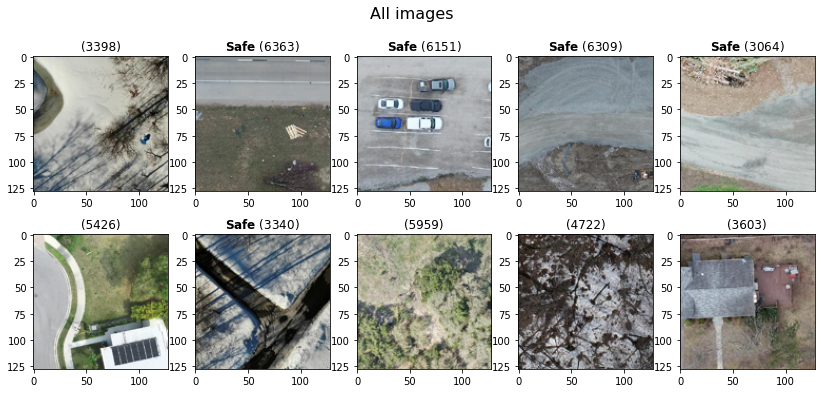

In [279]:
# VISUALIZER OF EDGE ORIENTATIONS OF RANDOM IMAGES

def visualize_labels(title, images, labels, seed=40):
    """Visualize a few images from our dataset!
    
    Args:
        title (str): Title of figure.
        images (np.ndarray): An array containing images. Shape should be (N, 64, 64, 3).
        labels (np.ndarray): An array of labels, 0 or 1. Shape should be (N, )
        seed (int): Seed used to generate random samples. Change this to see different samples!
    """
    # Validate inputs
    assert len(images.shape) == 4
    assert len(labels.shape) == 1
    assert labels.shape[0] == images.shape[0]
    assert images.shape[-1] == 3

    generator = np.random.RandomState(seed)
    fig, axes = plt.subplots(2, 5, figsize=(14, 6))
    for ax in axes.flatten():
        index = generator.randint(len(images))
        ax.imshow(images[index])
        #ax.imshow(normalize(convolve2d(rgb2hsl(images[index])[:,:,2], kernel_h)))
        #ax.imshow(edges(images_all[index]))
        if labels[index] == 1:
            ax.set_title(f"$\\bf{{Safe}}$ ({index})")
        else:
            ax.set_title(f"({index})")
    fig.suptitle(title, fontsize=16)


# Visualize some labels
visualize_labels("All images", images_all, labels_all)

In [240]:
# FEATURE EXTRACTION 
# AVERAGED BINS

def extract_features(images):
    final_hist = [] # =>0.2, =>0.4, =>0.6, =>0.8, =>1.0
    x = 0
    for img in images:
        x+=1
        if(x%100 == 0):
            print(x)
        rows, cols, channels = img.shape
        cr = int(rows/16)
        cc = int(rows/16)
        o_img = edges(img)
        #hist = [0,0,0,0,0]
        hist = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        
        
        for i in range(cr):
            for j in range(cc):
                current = np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 0])
                """
                if(current<0.2):
                    hist[0]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.4):
                    hist[1]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.6):
                    hist[2]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.8):
                    hist[3]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                else:
                    hist[4]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                """ 
                if(current<0.05):
                    hist[0]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.1):
                    hist[1]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.15):
                    hist[2]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.2):
                    hist[3]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.25):
                    hist[4]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.3):
                    hist[5]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.35):
                    hist[6]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.4):
                    hist[7]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.45):
                    hist[8]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.5):
                    hist[9]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.55):
                    hist[10]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.6):
                    hist[11]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.65):
                    hist[12]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.7):
                    hist[13]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.75):
                    hist[14]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.8):
                    hist[15]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.85):
                    hist[16]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.9):
                    hist[17]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                elif (current<0.95):
                    hist[18]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
                else:
                    hist[19]+=np.mean(o_img[i*cr:i*cr+cr, j*cc:j*cc+cc, 2])
        
        
        
        final_hist.append(hist)
            
    return np.array(final_hist)


features_all = extract_features(images_all)
print(features_all.shape)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
(6888, 20)


In [302]:
# FEATURE EXTRACTION WITH FLATTENED BINS

def extract_features_2 (images):
    x = 0 # progress checker
    final_hist = []
    for img in images:
        x+=1
        if(x%100 == 0):
            print(x)
        rows, cols, channels = img.shape
        cr = int(rows/8)
        cc = int(rows/8)
        o_img = edges(img)
        #img_hist = []
        
        for i in range(cr):
            for j in range(cc):
                #hist = [0,0,0,0,0]
                hist = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                for k in range(8):
                    for l in range(8):
                        """
                        if(o_img[i*k,j*l,0]<0.2):
                            hist[0]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.4):
                            hist[1]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.6):
                            hist[2]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.8):
                            hist[3]+= o_img[i*k,j*l,2]
                        else:
                            hist[4]+= o_img[i*k,j*l,2]
                        """
                        
                        if(o_img[i*k,j*l,0]<0.05):
                            hist[0]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.1):
                            hist[1]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.15):
                            hist[2]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.2):
                            hist[3]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.25):
                            hist[4]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.3):
                            hist[5]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.35):
                            hist[6]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.4):
                            hist[7]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.45):
                            hist[8]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.5):
                            hist[9]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.55):
                            hist[10]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.6):
                            hist[11]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.65):
                            hist[12]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.7):
                            hist[13]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.75):
                            hist[14]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.8):
                            hist[15]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.85):
                            hist[16]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.9):
                            hist[17]+= o_img[i*k,j*l,2]
                        elif (o_img[i*k,j*l,0]<0.95):
                            hist[18]+= o_img[i*k,j*l,2]
                        else:
                            hist[19]+= o_img[i*k,j*l,2]
        final_hist.append(np.array(hist).flatten())
        
    return np.array(normalize(final_hist))




features_all = extract_features_2(images_all)
print(features_all.shape)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
(6888, 20)


In [259]:
# CHARACTERISTIC OREINTATION

def extract_features_3 (images):
    x = 0 # progress checker
    final_hist = []
    for img in images:
        x+=1
        if(x%100 == 0):
            print(x)
        
        rows, cols, channels = img.shape
        o_img = edges(img)
        new_list = []
        hist = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        
        for i in range(rows):
            for j in range(cols):
                if(o_img[i,j,0]<0.05):
                    hist[0]+= o_img[i,j,2]
                elif(o_img[i,j,0]<0.1):
                    hist[1]+= o_img[i,j,2]
                elif(o_img[i,j,0]<0.15):
                    hist[2]+= o_img[i,j,2]
                elif(o_img[i,j,0]<0.2):
                    hist[3]+= o_img[i,j,2]
                elif(o_img[i,j,0]<0.25):
                    hist[4]+= o_img[i,j,2]
                elif(o_img[i,j,0]<0.3):
                    hist[5]+= o_img[i,j,2]
                elif(o_img[i,j,0]<0.35):
                    hist[6]+= o_img[i,j,2]
                elif(o_img[i,j,0]<0.4):
                    hist[7]+= o_img[i,j,2]
                elif(o_img[i,j,0]<0.45):
                    hist[8]+= o_img[i,j,2]
                elif(o_img[i,j,0]<0.5):
                    hist[9]+= o_img[i,j,2]
                elif(o_img[i,j,0]<0.55):
                    hist[10]+= o_img[i,j,2]
                elif(o_img[i,j,0]<0.6):
                    hist[11]+= o_img[i,j,2]
                elif(o_img[i,j,0]<0.65):
                    hist[12]+= o_img[i,j,2]
                elif(o_img[i,j,0]<0.7):
                    hist[13]+= o_img[i,j,2]
                elif(o_img[i,j,0]<0.75):
                    hist[14]+= o_img[i,j,2]
                elif(o_img[i,j,0]<0.8):
                    hist[15]+= o_img[i,j,2]
                elif(o_img[i,j,0]<0.85):
                    hist[16]+= o_img[i,j,2]
                elif(o_img[i,j,0]<0.9):
                    hist[17]+= o_img[i,j,2]
                elif(o_img[i,j,0]<0.95):
                    hist[18]+= o_img[i,j,2]
                else:
                    hist[19]+= o_img[i,j,2]
                """
                if(o_img[i,j,0]<0.2):
                    hist[0]+= o_img[i,j,2]
                elif (o_img[i,j,0]<0.4):
                    hist[1]+= o_img[i,j,2]
                elif (o_img[i,j,0]<0.6):
                    hist[2]+= o_img[i,j,2]
                elif (o_img[i,j,0]<0.8):
                    hist[3]+= o_img[i,j,2]
                else:
                    hist[4]+= o_img[i,j,2]
                """
                
        largest_bin = 0
        largest_index = 0
        
        for i in range (len(hist)): # find largest bin
            if(hist[i]>largest_bin):
                largest_bin = hist[i]
                largest_index = i
                        
        for j in range (largest_index,len(hist)): # shift bins
            new_list.append(hist[j])
        for j in range (0,largest_index):
            new_list.append(hist[j])
        break
        final_hist.append(new_list)
        
        
    return np.array(normalize(final_hist))

features_all = extract_features_3(images_all)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800


In [303]:
# TRAINING
# Get train / validation sets
(
    images_train,
    images_validation,
    features_train,
    features_validation,
    labels_train,
    labels_validation,
) = sklearn.model_selection.train_test_split(
    images_all,
    features_all,
    labels_all,
    train_size=0.75,
    random_state=42,
    shuffle=True,
)

# Print shapes of train + validation features and labels
print("Train images shape:\t", images_train.shape)
print("Train features shape:\t", features_train.shape)
print("Train labels shape:\t", labels_train.shape)
print()
print("Validation images shape:\t", images_validation.shape)
print("Validation features shape:\t", features_validation.shape)
print("Validation labels shape:\t", labels_validation.shape)

Train images shape:	 (5166, 128, 128, 3)
Train features shape:	 (5166, 20)
Train labels shape:	 (5166,)

Validation images shape:	 (1722, 128, 128, 3)
Validation features shape:	 (1722, 20)
Validation labels shape:	 (1722,)


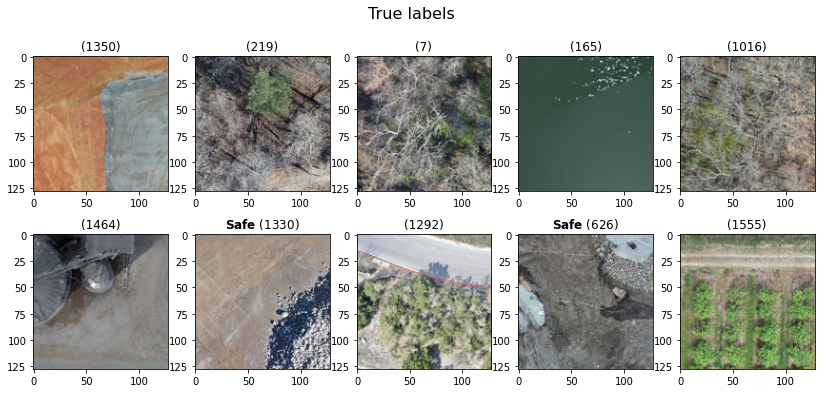

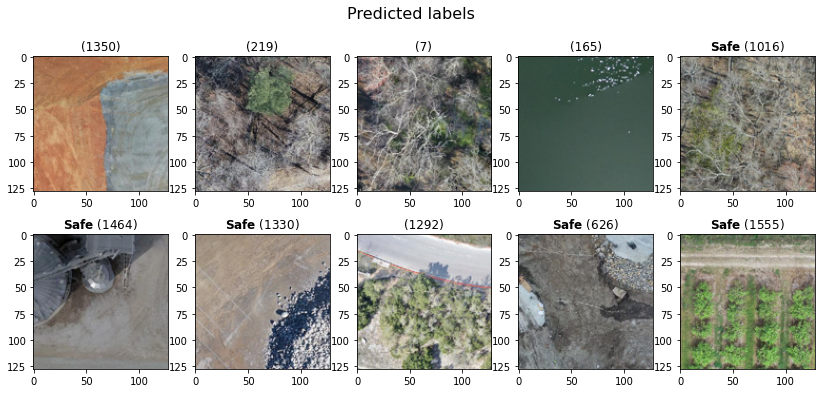

In [304]:
# PREDICTIONS

import sklearn.neighbors

classifier = sklearn.neighbors.KNeighborsClassifier(3)
classifier.fit(features_train, labels_train)

labels_validation_predicted = classifier.predict(features_validation)

visualize_labels("True labels", images_validation, labels_validation)
visualize_labels(
    "Predicted labels", images_validation, labels_validation_predicted
)

In [305]:
# CLASSIFICATION REPORT

import sklearn.metrics

report = sklearn.metrics.classification_report(labels_validation, labels_validation_predicted)

print("Classification report for", classifier)
print("=============================================================")
print("=============================================================")
print(report)

Classification report for KNeighborsClassifier(n_neighbors=3)
              precision    recall  f1-score   support

           0       0.63      0.58      0.60       898
           1       0.57      0.62      0.60       824

    accuracy                           0.60      1722
   macro avg       0.60      0.60      0.60      1722
weighted avg       0.60      0.60      0.60      1722

